<a href="https://colab.research.google.com/github/akariiijima/AdversarialExample/blob/master/AdversarialExampleByKeras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_579 (InputLayer)       (None, 784)               0         
_________________________________________________________________
dense_269 (Dense)            (None, 512)               401920    
_________________________________________________________________
dense_270 (Dense)            (None, 128)               65664     
_________________________________________________________________
dense_271 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_272 (Dense)            (None, 10)                650       
Total params: 476,490
Trainable params: 476,490
Non-trainable params: 0
_________________________________________________________________

What we want our adversarial example to look like: 2


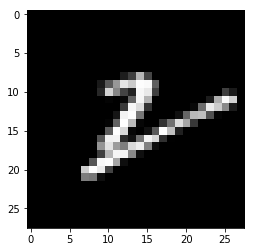



Adversarial Example: 


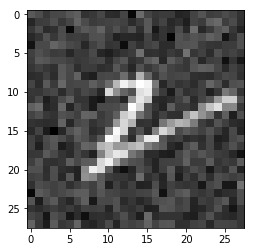

Network Prediction: 8

Network Output: 
[[0.08 0.09 0.11 0.05 0.13 0.12 0.06 0.12 0.14 0.09]]



In [74]:
def inputDerivative(model, x, goal):
    """ 
    Calculate derivatives wrt the intputs 
    model : model object
    x         : integer, random noise
    goal    : the goal output (one-hot)
    """
    # y_true : goal
    y_true = keras.layers.Input(shape=(10,))
    # ce : loss of goal and model's output
    ce = keras.losses.categorical_crossentropy(y_true, model.output)
    # grad_ce : gradients of loss(ce) and model's input
    grad_ce = tf.keras.backend.gradients(ce, model.inputs)
    
    # Create a function to be able to run this computation graph
    # INPUT    : [model.inputs(x), y_true(goal)]
    # OUTPUT: grad_ce 
    func = keras.backend.function(model.inputs + [y_true], grad_ce)
    output = func([x, goal])
    return output

def sneakyAdversarial(model, n, x_target, steps, eta, lam=0.5):
    """
    model      : model object
    n              : integer, our toal label
    x_target : numpy vector, our goal image for the adversarial example
    steps       : integer, number of steps for gradient descent
    eta           : integer, step size for gradient descent
    lam          : float, lambda, our regularization parameter. Default is 0.5
    """

    # Set the goal output (one-hot)
    goal = tf.keras.utils.to_categorical(n, 10)
    
    # Create a random noise
    # Average:0.5, Standard Deviation:0.3, Matrix shape is (1, 784)
    x = np.random.normal(0.5, 0.3, (1,784))
    
    # Gradient descent on the input
    for i in range(steps):
      # Calculate the derivative
      d = inputDerivative(model, x, goal)
      # The grads update on x, with an added penalty to the cost function
      x -= eta * (d[0] + lam * (x - x_target))
      
    return x

def sneakyGenerate(n, m):
    """
    n  : int 0-9, the target number to match
    m : index of example image to use (from the test set)
    """
    
    # Find random instance of m in test set
    idx = np.random.randint(0,10000)
    while np.where(y_test[idx] == 1)[0][0] != m: 
      idx += 1
    
    # Hardcode the parameters for the wrapper function
    a = sneakyAdversarial(model, n, x_test[idx], 10, 0.25)
    x = np.round(model.predict(a), 2)
    print('\nWhat we want our adversarial example to look like: ' + str(m))
    plt.imshow(x_test[idx].reshape((28,28)), cmap='gray')
    plt.show()
    print('\n')
    print('Adversarial Example: ')
    plt.imshow(a.reshape(28,28), cmap='gray')
    plt.show()
    print('Network Prediction: ' + str(np.argmax(x)) + '\n')
    print('Network Output: \n' + str(x) + '\n')
    return a

# x_*...PIXCEL (28, 28)
# y_*...LABEL (10, )
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)
# x_*...PIXCEL (784, )
x_train = x_train.reshape(60000,28*28)
x_test = x_test.reshape(10000,28*28)
# Normalization
x_train = x_train/255.
x_test = x_test/255.

# Layer
a = keras.layers.Input(shape=(28*28,))
x = keras.layers.Dense(units=512, activation='relu', input_shape=(28*28,))(a)
x = keras.layers.Dense(units=128, activation='relu')(x)
x = keras.layers.Dense(units=64, activation='relu')(x)
x = keras.layers.Dense(units=10, activation='softmax')(x)
# Model
model = keras.models.Model(inputs=a, outputs=x)
model.compile(optimizer=keras.optimizers.Adadelta(), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()
#model.fit(x_train, y_train, batch_size=64, epochs=5, validation_data=(x_test, y_test))


"""
a = keras.layers.Input(shape=(28*28,))
x = keras.layers.Conv2D(20, (3, 3), padding="valid", activation=tf.nn.relu,)(a)
x = keras.layers.MaxPooling2D(pool_size=(3,3))(x)
x = keras.layers.Conv2D(50, (3, 3), padding="valid", activation=tf.nn.relu,)(x)
x = keras.layers.MaxPooling2D(pool_size=(3,3))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(225, activation=tf.nn.relu)(x)
x = keras.layers.Dense(10, activation="softmax")(x)
"""


adversarialExample = sneakyGenerate(8, 2)